# Phase Field Benchmark
## Homogeneous nucleation, multiple seeds at random times
FiPy implementation of problem I.3 in "Phase Field Benchmark Problems for Nucleation", Wenkun Wu *et al.*, *Comp. Mat. Sci.* (in press)

## Import Python modules

In [16]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import fipy as fp
from fipy.tools import parallelComm

## Initialize mesh and solution variables

In [17]:
totaltime = 10.0
dt = 0.04

Lx = Ly = 100.
dx = dy = 0.8

nx = Lx // dx
ny = Lx // dy

mesh = fp.Grid2D(dx=dx, nx=nx, dy=dy, ny=ny)

phi = fp.CellVariable(mesh=mesh, name="$\phi$", value=0., hasOld=True)

elapsed = fp.Variable(name="$t$", value=0.)
    
x, y = mesh.cellCenters[0], mesh.cellCenters[1]

## Define governing equation

> [Set] the driving force to $\Delta f = \sqrt{2} / 12$

In [18]:
Delta_f = fp.numerix.sqrt(2.) / 12

> $$r_c = \frac{1}{3\sqrt{2}}\frac{1}{\Delta f} = 2.0$$

In [19]:
rc = 2.0

and define the governing equation 
> \begin{align}
\frac{\partial\phi}{\partial t} &= \nabla^2\phi - g'(\phi) + \Delta f p'(\phi) \tag{7}
\end{align}

> $$g(\phi) = \phi^2(1 - \phi)^2 \qquad p(\phi)=\phi^3(10 - 15\phi + 6\phi^2)$$

Following [`examples/phase/simple.py`](https://www.ctcms.nist.gov/fipy/examples/phase/generated/examples.phase.simple.html)


\begin{align}
\frac{\partial\phi}{\partial t}
&= \nabla^2\phi + m_\phi \phi (1 - \phi) \notag
\qquad\text{for $m_\phi \equiv -2(1 - 2\phi) + 30 \phi (1 - \phi) \Delta f$} \notag
\\
&= \nabla^2\phi + S \notag
\\
&\approx \nabla^2\phi + S|_\text{old}
+ \left.{\frac{\partial S}{\partial \phi}}\right|_\text{old} (\phi - \phi_\text{old}) 
\notag \\
&= \nabla^2\phi + \left(S - \frac{\partial S}{\partial \phi} \phi\right)_\text{old} 
+ \left.{\frac{\partial S}{\partial \phi}}\right|_\text{old} \phi \notag
\\
&= \nabla^2\phi + S_0 + S_1 \phi \notag
\\
S_0 &\equiv \left(S - \frac{\partial S}{\partial \phi} \phi\right)_\text{old}
\notag \\
&= m_\phi \phi_\text{old} (1 - \phi_\text{old}) - S_1 \phi_\text{old}
\notag \\
S_1 &\equiv \left.{\frac{\partial S}{\partial \phi}}\right|_\text{old}
\notag \\
&= \frac{\partial m_\phi}{\partial \phi} \phi (1 - \phi) + m_\phi (1 - 2\phi)
\notag
\end{align}

In [20]:
mPhi = -2 * (1 - 2 * phi) + 30 * phi * (1 - phi) * Delta_f
dmPhidPhi = 4 + 30 * (1 - 2 * phi) * Delta_f
S1 = dmPhidPhi * phi * (1 - phi) + mPhi * (1 - 2 * phi)
S0 = mPhi * phi * (1 - phi) - S1 * phi

eq = (fp.TransientTerm() == 
      fp.DiffusionTerm(coeff=1.) + S0 + fp.ImplicitSourceTerm(coeff=S1))

## Calculate total free energy

> \begin{align}
F[\phi] = \int\left[\frac{1}{2}(\nabla\phi)^2 + g(\phi) - \Delta f p(\phi)\right]\,dV \tag{6}
\end{align}

In [21]:
ftot = (0.5 * phi.grad.mag**2
        + phi**2 * (1 - phi)**2
        - Delta_f * phi**3 * (10 - 15 * phi + 6 * phi**2))
volumes = fp.CellVariable(mesh=mesh, value=mesh.cellVolumes)
F = ftot.cellVolumeAverage * volumes.sum()

## Define nucleation

> generate ... supercritical seeds with $r_0 = 1.1r^∗$. ... When adding a new seed, simply add the $\phi$ values given by the $\phi(r)$ profile
\begin{align}
\phi(x) &= \frac{1 - \tanh\left(\frac{x - x_0}{\sqrt{2}}\right)}{2}\tag{8}
\end{align}
to the $\phi$ values already in the domain, and handle the possible overlaps by setting $\phi = 1$ for all cells where $\phi > 1.$

In [22]:
def nucleus(x0, y0, r0):
    r = fp.numerix.sqrt((x - x0)**2 + (y - y0)**2)

    return (1 - fp.numerix.tanh((r - r0) / fp.numerix.sqrt(2.))) / 2

### Determine nucleation times
> 100 random nucleation times are generated, $t_1, \dots , t_{100}$, drawn
from a uniform distribution in the interval $t \in [0, t_{max})$ with centers $r$ drawn from a uniform
distribution on the domain

In [23]:
numnuclei = 100

if parallelComm.procID == 0:
    times = fp.numerix.random.random(numnuclei) * totaltime
    times.sort()
    nucleii = fp.numerix.concatenate((times[..., fp.numerix.newaxis],
                                      fp.numerix.random.random((numnuclei, 2))),
                                     axis=-1)
else:
    nucleii = None
nucleii = parallelComm.bcast(nucleii, root=0)

## Setup output

### Create particle counter

In [24]:
from scipy import ndimage

class LabelVariable(fp.CellVariable):
    """Label features in `var` using scipy.ndimage.label
    
    Parameters
    ----------
    var : ~fipy.variables.cellVariable.CellVariable
        Field to be labeled. Any values equal to or greater than `threshold`
        are counted as features and values below are considered the background.
        
        .. important:
           Only sensible if `var` is defined on a `...Grid...` Mesh.
    structure : array_like, optional
        A structuring element that defines feature connections.
        `structure` must be centrosymmetric
        (see ```scipy.ndimage.label`` Notes
        <https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html#scipy.ndimage.label>`_).
        If no structuring element is provided,
        one is automatically generated with a squared connectivity equal to
        one.  That is, for a 2-D `input` array, the default structuring element
        is::
            [[0,1,0],
             [1,1,1],
             [0,1,0]]
    threshold : float, optional
        Boundary value between features (inclusive) and background.
    dtype : date-type, optional
        The desired data-type for the labels. Note that the type must be able
        to store the largest label, or this Variable will raise an Exception.
        Default: int.
    """
    def __init__(self, var, structure=None, threshold=0.5, dtype=int):
        # We want our value to hold dtype,
        # but if we pass an array, the CellVariable
        # will probably be wonky
        value = fp.numerix.array(0.).astype(dtype).item()
        fp.CellVariable.__init__(self,
                                 mesh=var.mesh,
                                 value=value,
                                 elementshape=var.shape[:-1])
        self.var = self._requires(var)
        self.structure = structure
        self.threshold = threshold
        self.dtype = dtype
        self._num_features = None
    
    def _calcValue(self):
        """Label features of `var`
        
        Side-effect: sets self._num_features
        """
        arr = (self.var.globalValue > self.threshold).astype(self.dtype)
        shape = (self.var.mesh.args['nx'], self.var.mesh.args['ny'])
        arr = arr.reshape(shape)
        self._num_features = ndimage.label(input=arr,
                                           structure=self.structure,
                                           output=arr)
        return arr.flat
        
    @property
    def num_features(self):
        """How many objects were found
        """
        if self.stale or not self._isCached() or self._num_features is None:
            self._getValue()

        return self._num_features

In [25]:
labels = LabelVariable(phi, threshold=0.5)

### Collect statistics

In [26]:
def current_stats(elapsed):
    return [float(x) for x in [elapsed, phi.cellVolumeAverage, labels.num_features, F]]

stats = []
stats.append(current_stats(elapsed))

### Setup display

In [27]:
cmap = cm.get_cmap('brg', numnuclei)
newcolors = cmap(fp.tools.numerix.linspace(0, 1, numnuclei))
newcolors[0] = [0., 0., 0., 1.]
newcmap = ListedColormap(newcolors)

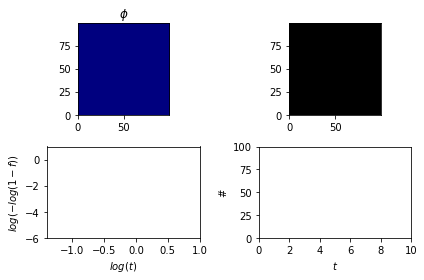

In [28]:
fig, axs = plt.subplots(2, 2)
phiViewer = fp.Viewer(vars=phi, datamin=0, datamax=1, axes=axs[0,0], colorbar=None)
labelViewer = fp.Viewer(vars=labels, datamin=0, axes=axs[0,1], colorbar=None, cmap=newcmap) # datamax=numnuclei/2, 

log10 = fp.tools.numerix.log10

avrline, = axs[1,0].plot([], [])
_ = axs[1,0].set_xlabel("$log(t)$")
_ = axs[1,0].set_ylabel("$log(-log(1-f))$")
axs[1,0].set_xlim(xmin=fp.tools.numerix.log10(dt), xmax=fp.tools.numerix.log10(totaltime))
axs[1,0].set_ylim(ymin=-6, ymax=1)

numline, = axs[1,1].plot([], [])
_ = axs[1,1].set_xlabel("$t$")
_ = axs[1,1].set_ylabel("#")
axs[1,1].set_xlim(xmin=0., xmax=totaltime)
axs[1,1].set_ylim(ymin=0., ymax=numnuclei)


fig.tight_layout()

## Solve and output

In [29]:
times = nucleii[..., 0]
times.sort()

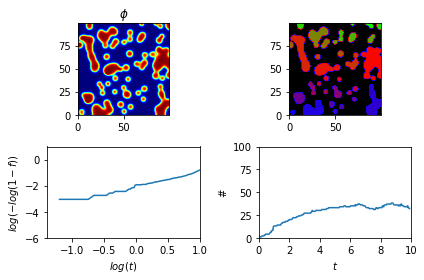

In [30]:
for until in times:
    while elapsed.value < until:
        phi.updateOld()
        dt_until = (until - elapsed).value
        dt_save = dt
        if dt_until < dt:
            dt = dt_until
        for sweep in range(5):
            eq.sweep(var=phi, dt=dt)
        elapsed.value = elapsed() + dt
        stats.append(current_stats(elapsed))
        dt = dt_save

    for tt, fx, fy in nucleii[nucleii[..., 0] == until]:
        phi.setValue(phi + nucleus(x0=fx * Lx, y0=fy * Ly, r0=1.1 * rc))
        phi.setValue(1., where=phi > 1.)
              
    phiViewer.plot()
    labelViewer.plot()
    t, f, N, FE = fp.numerix.array(stats).T
    
    avrline.set_xdata(log10(t))
    avrline.set_ydata(log10(-log10(1-f)))
    
    numline.set_xdata(t)
    numline.set_ydata(N)